# Проект: вариант 1 

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1) В первую очередь, его интересует показатель **retention**. Напишите функцию для его подсчета.

2) Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

3) Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1 
**Retention** – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

Формат данных:
 - shared/problem1-reg_data.csv – данные о времени регистрации
 - shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

### Блок импорта библиотек и предобработки данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss

%matplotlib inline

In [2]:
# импортируем данные
df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-c-balakaev/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-c-balakaev/shared/problem1-auth_data.csv', sep=';')

In [3]:
# посмотрим на пропуски в данных, их тип, структуру и наличие дубликатов

print('Структура данных:', '\n')
print('ДАТАФРЕЙМ df_reg:', '\n')
print(df_reg.head(), '\n')
print('ТИПЫ ДАННЫХ:', '\n')
print(df_reg.dtypes, '\n')
print('ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ', '\n')
print(df_reg.isna().sum(), '\n')
print('КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ:', '\n')
print(df_reg.shape[0], '\n')
print('ПОИСК ДУБЛИКАТОВ В ДАННЫХ', '\n')
print(df_reg.duplicated().sum())

Структура данных: 

ДАТАФРЕЙМ df_reg: 

      reg_ts  uid
0  911382223    1
1  932683089    2
2  947802447    3
3  959523541    4
4  969103313    5 

ТИПЫ ДАННЫХ: 

reg_ts    int64
uid       int64
dtype: object 

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ 

reg_ts    0
uid       0
dtype: int64 

КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ: 

1000000 

ПОИСК ДУБЛИКАТОВ В ДАННЫХ 

0


In [4]:
print('Структура данных:', '\n')
print('ДАТАФРЕЙМ df_auth:', '\n')
print(df_auth.head(), '\n')
print('ТИПЫ ДАННЫХ:', '\n')
print(df_auth.dtypes, '\n')
print('ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ', '\n')
print(df_auth.isna().sum())
print('КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ:', '\n')
print(df_auth.shape[0], '\n')
print('ПОИСК ДУБЛИКАТОВ В ДАННЫХ', '\n')
print(df_auth.duplicated().sum())

Структура данных: 

ДАТАФРЕЙМ df_auth: 

     auth_ts  uid
0  911382223    1
1  932683089    2
2  932921206    2
3  933393015    2
4  933875379    2 

ТИПЫ ДАННЫХ: 

auth_ts    int64
uid        int64
dtype: object 

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ 

auth_ts    0
uid        0
dtype: int64
КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ: 

9601013 

ПОИСК ДУБЛИКАТОВ В ДАННЫХ 

0


### Выводы
- Данные представлены двумя таблицами
- Пропусков нет
- Дубликатов нет
- В датафреймах 1000000 пользователей и 9601013 запусков приложения

#### Блок работы с временными промежутками

In [5]:
# Для работы с временными промежутками и высчисления retention нам необходимо преобразовать их в соответствующий формат.
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

In [6]:
# Посмотрим за какой период наш датафрейм.
print(f" Начало периода df_reg: {df_reg.reg_ts.min()}, Конец периода df_reg: {df_reg.reg_ts.max()}", '\n')
print(f" Начало периода df_auth: {df_auth.auth_ts.min()}, Конец периода df_auth: {df_auth.auth_ts.max()}", '\n')

 Начало периода df_reg: 1998-11-18 09:43:43, Конец периода df_reg: 2020-09-23 15:17:24 

 Начало периода df_auth: 1998-11-18 09:43:43, Конец периода df_auth: 2020-09-23 15:17:24 



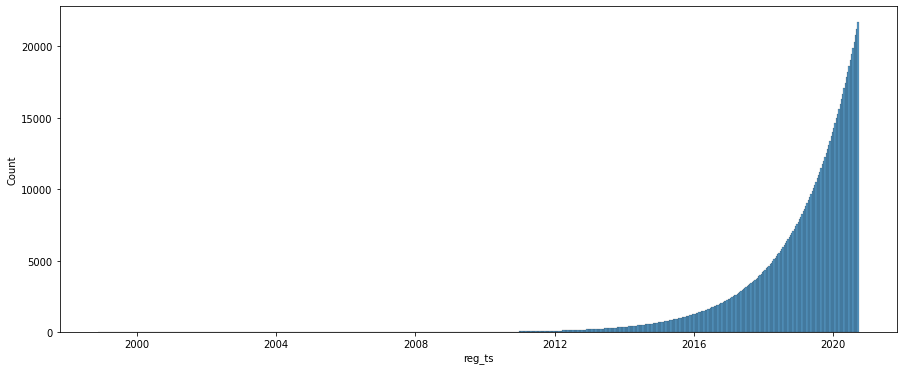

In [7]:
# Построим графики распределения активности пользователей за все время
plt.figure(figsize=(15, 6))
sns.histplot(df_reg, x='reg_ts')

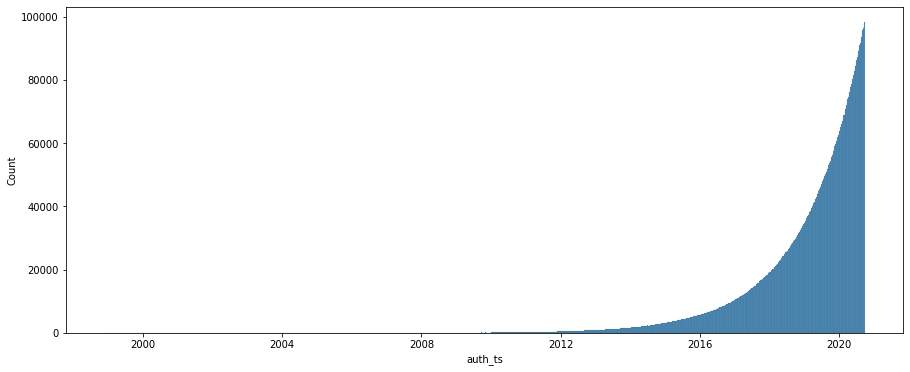

In [8]:
plt.figure(figsize=(15, 6))
sns.histplot(df_auth, x='auth_ts')

#### Наблюдения

Мы видим что до 2012 года была очень маленькая активность пользователей. Начиная с 2012 графики ведут себя практически экспоненциально - наблюдается "взрывной" рост активности. Тому может быть множество причин, как-то: развитие технологий и графических ускорителей, выход на новые рынки сбыта, появление более продвинутых стандартов связи, грамотная работа маркетологов, реклама.

## Блок построения функции retention

Функция расчета **retention** включает в себя:
   
- df_reg - данные о времени регистрации
- df_auth - данные о времени запуска приложения
- start_date - начальная дата
- end_date - конечная дата        
- days - период (в днях)

Предоставленный код определяет функцию, которая вычисляет показатель удержания пользователей (retention rate) для заданного интервала дат регистрации. Функция выполняет необходимую обработку данных, фильтрует и группирует их в когорты, а затем создаёт визуализацию показателя удержания в виде тепловой карты (heatmap) в заданном периоде.

In [9]:
def get_retention(df_reg, df_auth, start_date, end_date, days):
    
    # Считываем данныe
    df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
    df_auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')
    
    # Переводим временные промежутки в Unix-формат
    df_reg['reg_ts'] = pd.to_datetime(df_reg.reg_ts, unit='s').dt.date
    df_auth['auth_ts'] = pd.to_datetime(df_auth.auth_ts, unit='s').dt.date

    # Мерджим таблицы, считаем разницу между днем авторизации и днем регистрации
    df_main = df_auth.merge(df_reg, on='uid')   
    df_main['day_diff'] = (df_main.auth_ts - df_main.reg_ts).dt.days
    df_main = df_main[df_main.day_diff <= days]
    
    # Задаем необходимый промежуток
    df_main = df_main[pd.to_datetime(df_main['reg_ts']).between(pd.to_datetime(start_date), pd.to_datetime(end_date))]
    
    # Группируем в когорты
    df_cohorts = df_main.groupby(['reg_ts', 'day_diff']).agg({'uid': pd.Series.nunique}).reset_index() 
    pivot_cohorts = df_cohorts.pivot(index='reg_ts', columns='day_diff', values='uid')
    retention_rate = pivot_cohorts.divide(pivot_cohorts[0], axis=0)
    
    retention_rate[0] = pivot_cohorts[0].apply(int)
    
    # Визуализируем
    plt.figure(figsize=(20, 15))
    plt.title('Retention rate', fontsize=20)
    
    # Строим тепловую карту
    sns.heatmap(retention_rate, annot=True, vmin=0.0, vmax=0.10, 
                cmap='YlGnBu', linewidths=3, linecolor='black', fmt='.2%')
 
    # Задаем оси
    plt.xlabel('Days After Registration', fontsize=15)
    plt.ylabel('Registration Date', fontsize=15)
    
    plt.show()

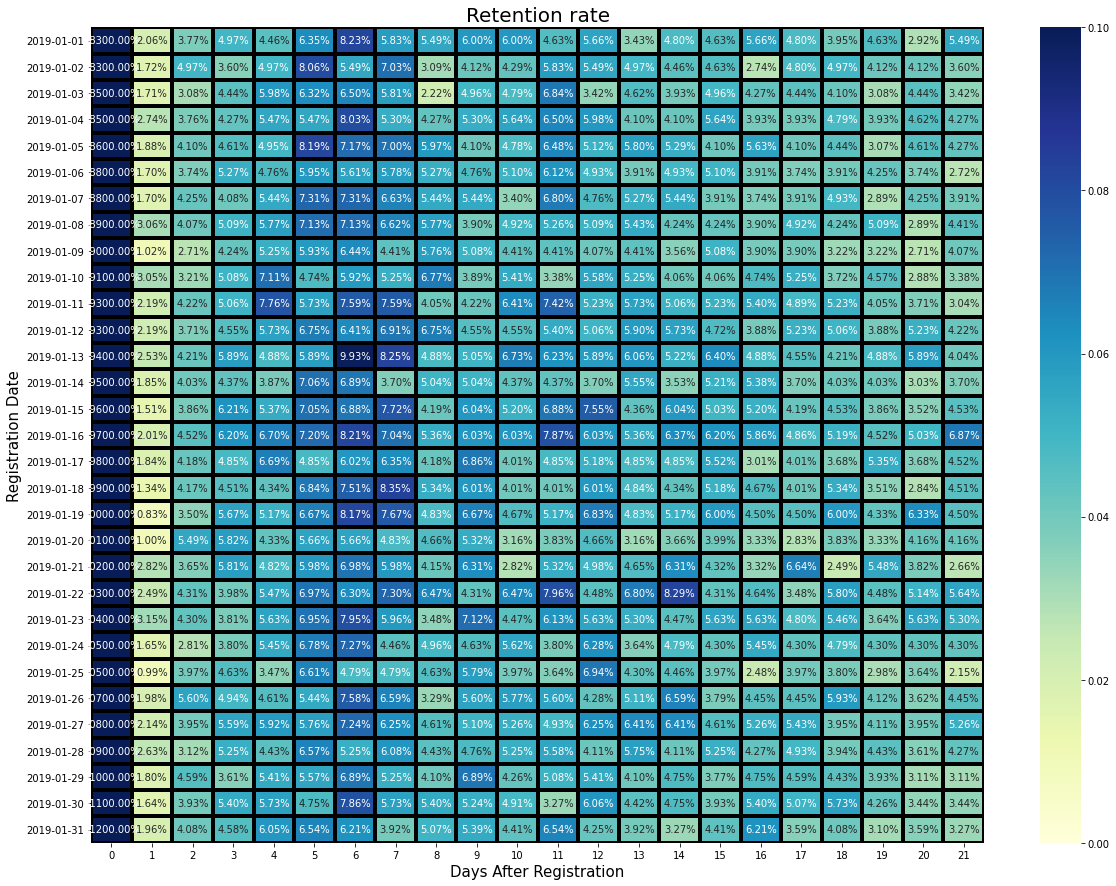

In [10]:
get_retention(df_reg, df_auth, '2019-01-01', '2019-01-31', 21)

### Выводы

Показатель **retention** растет линейно достигая своего пика на 5-7 день после регистрации. То есть пользователи доходят до пика интереса, а затем наблюдается постепенный спад. Это может быть вызвано проблемами как с техническими аспектами игры, так и с гейплеем. Возможно стоит поработать с игровой механикой, ввести бонусы каждый день с внутриигровой валютой, улучшить сам код и оптимизацию, можно придумать различные внутриигровые ивенты завязанные на днях недели. Возможно стоит больше вложиться в таргетированную рекламу. 

## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

### Блок импорта и предобработки данных

In [11]:
# Импортируем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-c-balakaev/Проект_1_Задание_2.csv', sep=';')

In [12]:
# Посмотрим на пропуски в данных, их тип, структуру и наличие дубликатов
print('Структура данных:', '\n')
print('ДАТАФРЕЙМ df:', '\n')
print(df.head(), '\n')
print('ТИПЫ ДАННЫХ:', '\n')
print(df.dtypes, '\n')
print('ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ', '\n')
print(df.isna().sum(), '\n')
print('КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ:', '\n')
print(df.shape[0], '\n')
print('ПОИСК ДУБЛИКАТОВ В ДАННЫХ', '\n')
print(df.duplicated().sum())

Структура данных: 

ДАТАФРЕЙМ df: 

   user_id  revenue testgroup
0        1        0         b
1        2        0         a
2        3        0         a
3        4        0         b
4        5        0         b 

ТИПЫ ДАННЫХ: 

user_id       int64
revenue       int64
testgroup    object
dtype: object 

ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ 

user_id      0
revenue      0
testgroup    0
dtype: int64 

КОЛИЧЕСТВО СТРОК В ДАТАФРЕЙМЕ: 

404770 

ПОИСК ДУБЛИКАТОВ В ДАННЫХ 

0


In [13]:
# Разделим данные на контрольную и тестовую группы
control = df[df.testgroup == 'a']
test = df[df.testgroup == 'b']

### Блок проверки показателей из условия

In [14]:
# Рассчитаем ARPU в контрольной группе
arpu_control = control.groupby('testgroup').revenue.mean().values[0]
print('ARPU в контрольной группе:', arpu_control, '\n')

# Расчитаем ARPU в тестовой группе
arpu_test = test.groupby('testgroup').revenue.mean().values[0]
print('ARPU в тестовой группе:', arpu_test, '\n')

# Посчитаем разницу
diff_arpu = 100 - (arpu_control / arpu_test * 100)
print('Разница(%):', diff_arpu)

ARPU в контрольной группе: 25.413719736965806 

ARPU в тестовой группе: 26.75128659327863 

Разница(%): 5.000009444962146


Действительно, **ARPU** в тестовой группе выше на 5%.

**Посчитаем выручку в группах**.

In [15]:
# Выручка в контрольной группе
print('Выручка в контрольной группе:', control.groupby('testgroup').revenue.sum().values[0], '\n')

# Выручка в тестовой группе
print('Выручка в тестовой группе:', test.groupby('testgroup').revenue.sum().values[0])

Выручка в контрольной группе: 5136189 

Выручка в тестовой группе: 5421603


**Посчитаем количество платящих пользователей**

In [16]:
# Количество платящих пользователей в контрольной группе
print('Количество платящих пользователей в контрольной группе:', control[control.revenue > 0].shape[0], '\n')

# Количество платящих пользователей в тестовой группе
print('Количество платящих пользователей в тестовой группе:', test[test.revenue > 0].shape[0])

Количество платящих пользователей в контрольной группе: 1928 

Количество платящих пользователей в тестовой группе: 1805


Мы убедились что показатели совпадают с условиями. Попробуем проанализировать результаты. 

Для начала посчитаем **ARPPU** - среднюю выручку на платящего пользователя.

In [17]:
# ARPPU в контрольной группе
arppu_control = control[control.revenue > 0].groupby('testgroup').agg({'revenue': 'mean'}).values[0][0]
print('ARPPU в контрольной группе:', arppu_control, '\n')

# ARPPU в тестовой группе
arppu_test = test[test.revenue > 0].groupby('testgroup').agg({'revenue': 'mean'}).values[0][0]
print('ARPPU в тестовой группе', arppu_test, '\n')

# Посчитаем разницу
diff_arppu = 100 - (arppu_control / arppu_test * 100)
print('Разница(%)', diff_arppu)

ARPPU в контрольной группе: 2663.9984439834025 

ARPPU в тестовой группе 3003.6581717451522 

Разница(%) 11.308201810607642


**ARPPU** в тестовой группе выше на 11%

**Посчитаем конверсию в группах**

In [18]:
# CR в контрольной группе
print('CR в контрольной группе:', control[control.revenue > 0].shape[0] / control.shape[0] * 100, '\n')

# CR в тестовой группе
print('CR в тестовой группе:', test[test.revenue > 0].shape[0] / test.shape[0] * 100, '\n')

CR в контрольной группе: 0.9539690157988748 

CR в тестовой группе: 0.8906235351586593 



### Выбор параметрического критерия


Нам нужно понять какой параметрический критерий применить для анализа результатов. 

Когда анализируются результаты А/Б-теста и требуется определить, есть ли статистически значимые различия между двумя группами, обычно используют статистические критерии. Для сравнения распределений и определения значимости различий можно применить различные статистические тесты, такие как t-тест, z-тест или непараметрические тесты, в зависимости от характеристик данных и предположений о распределении.

Одним из возможных подходов для анализа результатов А/Б-теста в вашем случае может быть разделение анализа на две части. Сначала можно проанализировать распределение всех пользователей, чтобы оценить общие различия между группами в целом. Затем можно проанализировать распределение только платящих пользователей в каждой группе, чтобы понять, как акционные предложения влияют на эту подгруппу отдельно.

Для сравнения распределений платящих пользователей в разных группах можно использовать аналогичные статистические критерии, такие как t-тест для независимых выборок или непараметрические аналоги, например, тест Манна-Уитни. Это позволит определить, есть ли статистически значимые различия в поведении платящих пользователей в разных группах и влияют ли акционные предложения на их поведение.

Важно также учитывать размер выборки и уровень значимости при интерпретации результатов и принятии решений на основе статистического анализа.

Посмотрим на гистограмму распределений, чтобы определеть какие распределения у нас, есть ли в них выбросы, являются ли они нормальными.

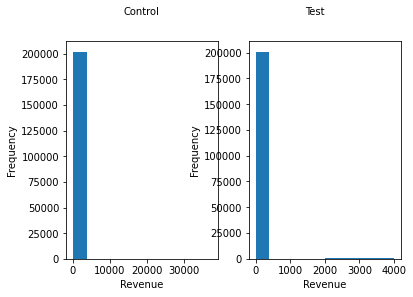

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False)

ax2.hist(test.revenue)
ax1.hist(control.revenue)

ax2.set_xlabel('Revenue')
ax2.set_ylabel('Frequency')

ax1.set_xlabel('Revenue')
ax1.set_ylabel('Frequency')

plt.text(.7, 1, 'Test', transform=fig.transFigure, horizontalalignment='center', verticalalignment='top')
plt.text(.3, 1, 'Control', transform=fig.transFigure, horizontalalignment='center', verticalalignment='top')

plt.show()

Мы сразу можем заметить в тестовой группе есть выбросы. Воспользуемся критерием Шапиро-Уилка для проверки распределений на нормальность. Так как критерий Шапиро-Уилка плохо работает с большими выборками, возьмем рэндомные сэмплы из выборок.

H0 - распределение нормальное

H1 - распределние статистически значимо отличается от нормального

P-value: 0.05

In [20]:
ss.shapiro(control.revenue.sample(1000, random_state=100))

ShapiroResult(statistic=0.02232915163040161, pvalue=0.0)

In [21]:
ss.shapiro(test.revenue.sample(1000, random_state=100))

ShapiroResult(statistic=0.0978769063949585, pvalue=0.0)

#### Вывод ####
Мы убедились что распределение ненормальное, с выбросами. Так как наше p-value < 0.05, по критерию Шапиро-Уилка наше распределение `статистически значимо отличается от нормального`.

Посмотрим на распределения только платящих пользователей, проверим есть ли стат-значимые различия между этими группами. Построим гистораммы распределения.

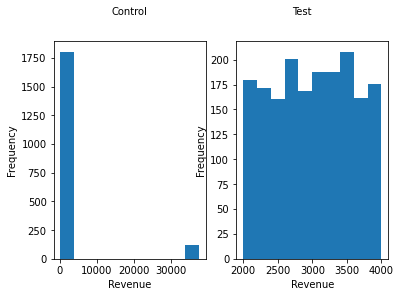

In [22]:
fig, (ax3, ax4) = plt.subplots(1, 2, sharex=False)

ax3.hist(control[control.revenue > 0].revenue)
ax4.hist(test[test.revenue > 0].revenue)

ax3.set_xlabel('Revenue')
ax3.set_ylabel('Frequency')

ax4.set_xlabel('Revenue')
ax4.set_ylabel('Frequency')

plt.text(.7, 1, 'Test', transform=fig.transFigure, horizontalalignment='center', verticalalignment='top')
plt.text(.3, 1, 'Control', transform=fig.transFigure, horizontalalignment='center', verticalalignment='top')

plt.show()

In [23]:
# Разделим пользователей по выручке в контрольной группе
pd.cut(
    df.query('testgroup == "a" and  revenue > 0').revenue,
    bins=[0, 1000, 35000, 50000],
    labels=["<1000", "1000 - 35 000", ">35 000"]
).value_counts()

<1000            1805
>35 000           123
1000 - 35 000       0
Name: revenue, dtype: int64

В контрольной группе есть 123 пользователя, которые совершают покупку на сумму более 35000

In [24]:
# Разделим пользователей по выручке в тестовой группе
pd.cut(
    df.query('testgroup == "b" and  revenue > 0').revenue,
    bins=[0, 2000, 4000, 10000],
    labels=["<2000", "2000 - 4000", ">4000"]
).value_counts()

2000 - 4000    1804
<2000             1
>4000             0
Name: revenue, dtype: int64

В тестовой группе распределение равномерное.

### Предварательные выводы

Исходя из предварительного итога, похоже, что есть необычное распределение пользователей между группами A и B. Группа A содержит 123 пользователя с очень высокой выручкой (revenue)

Из этой ситуации возникают две возможные гипотезы:

1) Дизайн теста был выполнен неправильно (возможно, произошла ошибка в сплитовании пользователей) - в таком случае, рекомендуется провести тест заново с улучшенным дизайном.

2) Дизайн пользователей был выполнен хорошо, и фича, которая была протестирована, действительно мотивирует пользователей совершать очень дорогие покупки. В таком случае, следует проанализировать полученные данные и убедиться в статистической значимости результатов. Если результаты подтверждают положительное влияние фичи на крупные покупки, то можно рекомендовать ее использование в будущих маркетинговых стратегиях.

Мы будем исходить из второго кейса

### Тестирование

Давайте проверим есть ли различия между этими пользователями. Воспользуемся бутстрэп-методом, который основан на многократной генерации выборок с возвращением из исходной выборки. Он позволяет оценить характеристики выборки, такие как среднее, медиана, доверительный интервал и другие, путем создания множества бутстрэп-выборок и анализа распределения статистик, полученных из этих выборок. 

В нашей задаче будем сравнивать медианы, так как в данных есть много выбросов, что критично для бутстрэпа, так как он чувствителен к ним, и тогда мы рискуем совершить ошибку первого рода (мы делаем вывод о наличии значимых различий или эффекта, когда на самом деле таких различий нет.)

H0 - группы не отличаются

H1 - отличия в группах статистически значимы

P-value = 0.95

In [25]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    # Считаем размер бут-выборок   
    boot_data = []
    for i in range(boot_it):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values

        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

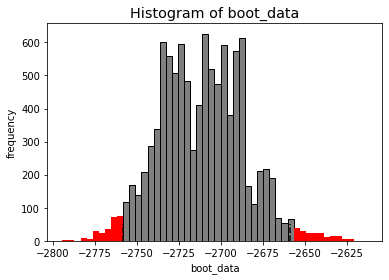

In [26]:
# Применим бутстрап для сравнения медиан, возьмем 10000 бут выборок
boot_median = get_bootstrap(
    control[control.revenue > 0].revenue,
    test[test.revenue > 0].revenue, 
    boot_it=10000, 
    statistic=np.median
)

Если график распределения разности медиан показывает, что значения не пересекают ноль и существует значительное количество значений с одним знаком разности, это может быть индикатором статистически значимых различий между группами. Однако, для получения более точной и количественной оценки статистической значимости различий, следует вычислить p-уровень значимости. 

In [27]:
print(f"P-value для сравнения медиан: {boot_median['p_value']}", '\n')

print(f"Доверительный интервал для разности медиан: {boot_median['quants']}")

P-value для сравнения медиан: 0.0 

Доверительный интервал для разности медиан:             0
0.025 -2758.5
0.975 -2659.0


#### Вывод####
Р-уровень значимости нам говорит о том, что различия в этих группах `статистически значимы`.

### CR

Сравним конверсию в покупку среди наших групп. Для этого построим таблицу сопряженности, в которой укажем количество платящих и неплатящих пользователей.

In [28]:
# преобразуем revenue в булевый тип данных
df["revenue"] = df["revenue"].astype(bool)

In [29]:
# создадим таблицу сопряженности
crosstab = df.groupby("testgroup").agg({"user_id": "count", "revenue": "sum"})

Применим метод Хи-квадрат (критерий согласия Пирсона) для проверки статистической связи между категориальными переменными.

H0 - конверсии в группах статистически значимо не отличаются

H1 - конверсии в группах отличаются

P-value = 0.05

In [30]:
# применяем метод
stat, pval, dof, expected = ss.chi2_contingency(crosstab)
pval

0.03824373651044168

Исходя из полученного значения p-value равного 0.038 при выбранном уровне значимости 0.05, мы можем сделать вывод о статистически значимом различии в конверсии в оплату между контрольной и тестовой группами. Таким образом, на основе имеющихся данных, можно сказать, `что конверсия в оплату в контрольной группе статистически значимо выше, чем в тестовой группе`.

### Итоги

Если мы допускаем что дизайн эксперимента не был нарушен, то мы можем сделать следующие выводы:

1) При сравнении всех пользователей, включая и платящих и не платящих, статистически значимых различий между группами не обнаружено. Это означает, что акционные предложения, предоставленные тестовой группе, не оказали статистически значимого влияния на общую аудиторию игроков.

2) Однако, если сравнить только платящих пользователей, выявляются статистически значимые различия между группами. Это говорит о том, что акционные предложения имеют положительный эффект на платящих пользователей и способствуют повышению ключевых метрик, связанных с доходом или активностью платежей.

3) Конверсия в покупку статистически значимо выше в контрольной группе

На основе этих результатов можно рекомендовать использовать набор акционных предложений, предоставленный тестовой группе, в дальнейшем. Он демонстрирует статистически значимое улучшение показателей среди платящих пользователей. Однако, следует учесть, что данная рекомендация основана на предположении, что выборка и методология анализа были надлежащими, и нет других факторов, которые могли повлиять на результаты.

## Задание 3

В игре **Plants & Gardens** каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

 

Для оценки результатов последнего прошедшего события в игре **Plants & Gardens** можно использовать следующие метрики:

- `Прохождение уровней`: Оценка количества уровней, пройденных игроком за время события. Эта метрика позволяет определить, насколько успешно игроку удалось прогрессировать в событии и достичь поставленных целей.


- `Время завершения`: Оценка времени, затраченного игроком на прохождение события. Быстрое завершение события может свидетельствовать о высоком уровне навыков и эффективной стратегии игрока.


- `Количество ошибок`: Оценка количества ошибок, допущенных игроком во время прохождения уровней. Меньшее количество ошибок может указывать на лучшую игровую стратегию и навыки игрока.


- `Полученные награды`: Оценка полученных игроком уникальных предметов для сада и персонажей, дополнительных монет или бонусов. Эта метрика позволяет измерить успешность игрока в том, что касается получения и использования наград, которые были доступны в рамках события.

Если в другом событии усложнена механика так, что при неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад, набор метрик для оценки результатов может измениться. В таком случае можно добавить следующую метрику:


- `Количество откатов`: Оценка количества откатов, сделанных игроком во время события. Эта метрика позволяет измерить сложность уровней и эффективность игрока в их преодолении. Меньшее количество откатов может указывать на более опытного игрока или лучшую адаптацию к измененной механике события.
Таким образом, в случае изменения механики событий с откатом уровней, метрики оценки результатов могут включать информацию о количестве откатов, чтобы более точно оценить успешность игрока в новых условиях игры.